In [2]:
#imports
import pandas as pd
import json
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr


In [3]:
# Load sleep data
sleep_data = pd.read_csv('sleep-data.csv', delimiter=';')

# Convert datetime columns to proper datetime objects
sleep_data['Went to bed'] = pd.to_datetime(sleep_data['Went to bed'])
sleep_data['Woke up'] = pd.to_datetime(sleep_data['Woke up'])

# Load watch history JSON
with open('watch-history.json', 'r', encoding='utf-8') as f:
    watch_history = json.load(f)

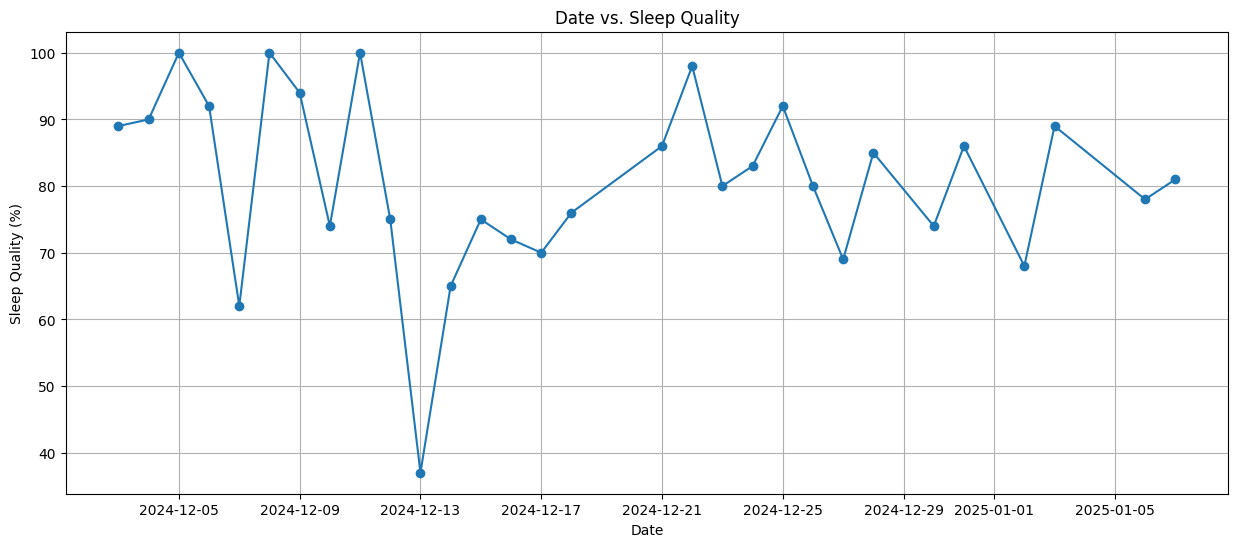

In [4]:
# Load sleep data
#sleep_data = pd.read_csv('/mnt/data/My complete sleep data.csv', delimiter=';')
sleep_data = pd.read_csv('sleep-data.csv', delimiter=';')
# Convert datetime columns to proper datetime objects
sleep_data['Went to bed'] = pd.to_datetime(sleep_data['Went to bed'])
sleep_data['Woke up'] = pd.to_datetime(sleep_data['Woke up'])

# Ensure sleep quality is numeric
sleep_data['Sleep Quality'] = sleep_data['Sleep Quality'].str.replace('%', '').astype(float)

# Extract date from 'Went to bed'
sleep_data['Date'] = sleep_data['Went to bed'].dt.date

# Load watch history JSON
#with open('/mnt/data/watch-history 2.json', 'r', encoding='utf-8') as f:
    #watch_history = json.load(f)
with open('watch-history.json', 'r', encoding='utf-8') as f:
    watch_history = json.load(f)
# Convert watch history into a DataFrame and process timestamps
watch_data = pd.DataFrame(watch_history)

# Use format='mixed' to handle mixed datetime formats
watch_data['time'] = pd.to_datetime(watch_data['time'], format='mixed', errors='coerce')

# Drop rows where time conversion failed
watch_data = watch_data.dropna(subset=['time'])

# Extract date and hour
watch_data['date'] = watch_data['time'].dt.date
watch_data['hour'] = watch_data['time'].dt.hour

# 1. Plot Date vs. Sleep Quality
plt.figure(figsize=(15, 6))
plt.plot(sleep_data['Date'], sleep_data['Sleep Quality'], marker='o', linestyle='-')
plt.title('Date vs. Sleep Quality')
plt.xlabel('Date')
plt.ylabel('Sleep Quality (%)')
plt.grid()
plt.show()


In [5]:
# Perform data cleaning for sleep_data
# Get the following fields date Use Sleep Quality, Time in bed(seconds), Time asleep (seconds), Regularity, Asleep after (seconds), Movements per hour
sleep_data_cleaned = sleep_data[['Date', 'Sleep Quality', 'Time in bed (seconds)', 'Time asleep (seconds)', 'Regularity', 'Asleep after (seconds)', 'Movements per hour']]
sleep_data_cleaned['Regularity'] = sleep_data_cleaned['Regularity'].replace({'—': np.nan, '%': ''}, regex=True)

# Drop rows with NaN in the 'Regularity' column or handle them appropriately
sleep_data_cleaned['Regularity'] = pd.to_numeric(sleep_data_cleaned['Regularity'], errors='coerce')

# Convert percentage values to decimal (e.g., 90 -> 0.9)
sleep_data_cleaned['Regularity'] = sleep_data_cleaned['Regularity'] / 100

# If you want to drop rows with NaN in 'Regularity' after conversion
sleep_data_cleaned = sleep_data_cleaned.dropna(subset=['Regularity'])





C:\Users\tunae\AppData\Local\Temp\ipykernel_30188\2214886702.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sleep_data_cleaned['Regularity'] = sleep_data_cleaned['Regularity'].replace({'—': np.nan, '%': ''}, regex=True)
C:\Users\tunae\AppData\Local\Temp\ipykernel_30188\2214886702.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sleep_data_cleaned['Regularity'] = pd.to_numeric(sleep_data_cleaned['Regularity'], errors='coerce')
C:\Users\tunae\AppData\Local\Temp\ipykernel_30188\2214886702.py:10: Settin

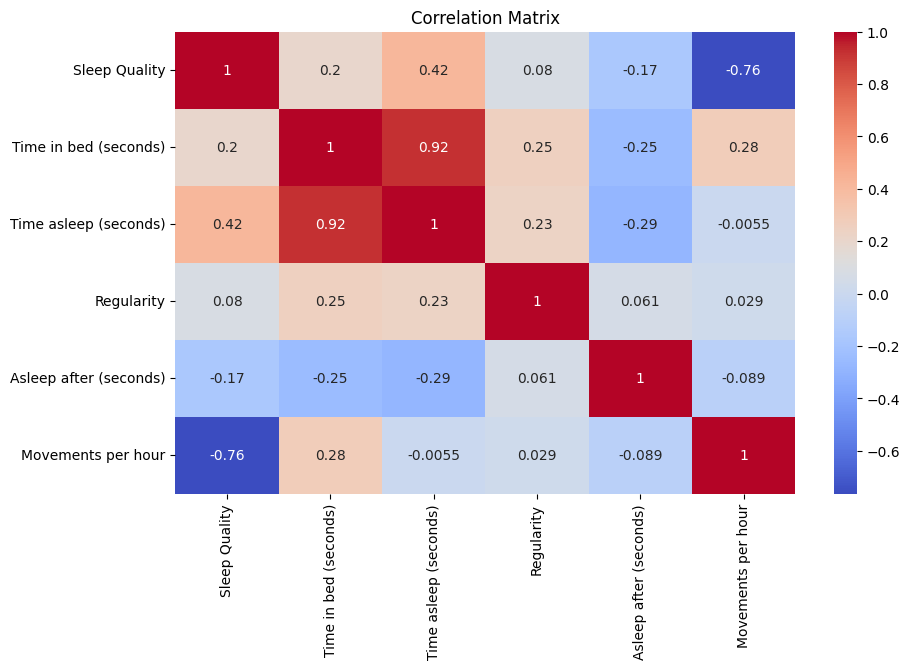

In [6]:
# Create heatmap using sleep_data_cleaned with fields Sleep Quality, Time in bed(seconds), Time asleep (seconds), Regularity, Asleep after (seconds), Movements per hour

# Create a correlation matrix
sleep_data_heatmap = sleep_data_cleaned[['Sleep Quality', 'Time in bed (seconds)', 'Time asleep (seconds)', 'Regularity', 'Asleep after (seconds)', 'Movements per hour']]
corr = sleep_data_heatmap.corr()

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


<Figure size 1200x800 with 0 Axes>

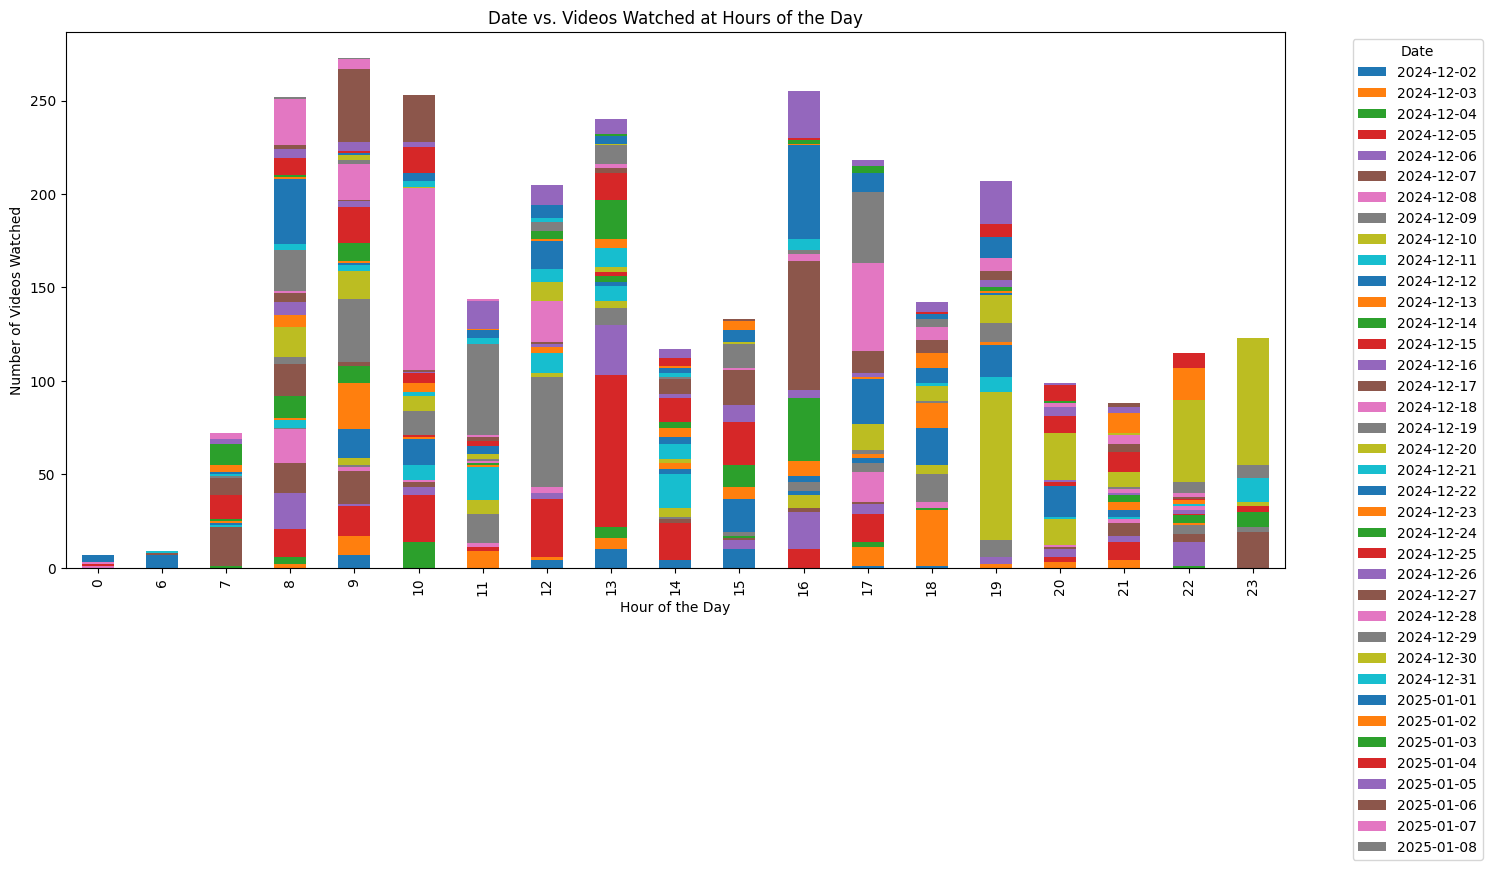

In [7]:
# 2. Plot Date vs. Videos Watched at Hours of the Day
watch_count_by_hour = watch_data.groupby(['date', 'hour']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 8))
watch_count_by_hour.T.plot(kind='bar', stacked=True, figsize=(15, 8))
plt.title('Date vs. Videos Watched at Hours of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Videos Watched')
plt.legend(title='Date', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



In [8]:
# Adjust the bins for time periods to include 10 PM to 4 AM as "night"
"""
Night: 10 PM to 4 AM
Morning: 4 AM to 11 AM
Afternoon: 11 AM to 5 PM
Evening: 5 PM to 10 PM
"""
watch_data['hour'] = watch_data['time'].dt.hour
watch_data['period'] = pd.cut(
    watch_data['hour'], 
    bins=[-1, 4, 11, 17, 22, 24], 
    labels=['night', 'morning', 'afternoon', 'evening', 'night'], 
    right=False, 
    ordered=False
)

# Handle the case where hours wrap around at midnight
watch_data['period'] = watch_data['period'].replace({'night': 'night'}).fillna('night')

# Calculate total watch time per day for different time periods
watch_data_daily_periods = watch_data.groupby(['date', 'period']).size().unstack(fill_value=0).reset_index()

# Merge the new period-based data with daily totals
watch_data_daily = watch_data.groupby('date').size().reset_index(name='count')
watch_data_daily = watch_data_daily.merge(watch_data_daily_periods, on='date', how='left')

# Convert all period columns to integers
periods = ['night', 'morning', 'afternoon', 'evening']
for period in periods:
    if period in watch_data_daily.columns:
        watch_data_daily[period] = watch_data_daily[period].astype(int)

# Merge sleep and watch data
merged_data = sleep_data_cleaned.merge(watch_data_daily, left_on='Date', right_on='date', how='left')


C:\Users\tunae\AppData\Local\Temp\ipykernel_30188\2066953613.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  watch_data_daily_periods = watch_data.groupby(['date', 'period']).size().unstack(fill_value=0).reset_index()


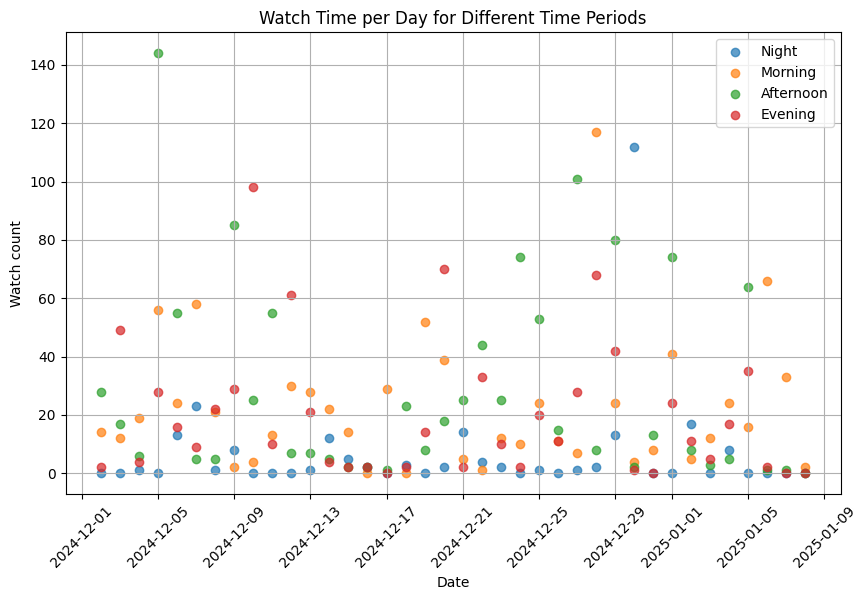

In [9]:
# Create a scatter plot of watch time per day for different time periods
plt.figure(figsize=(10, 6))
plt.scatter(watch_data_daily['date'], watch_data_daily['night'], label='Night', alpha=0.7)
plt.scatter(watch_data_daily['date'], watch_data_daily['morning'], label='Morning', alpha=0.7)
plt.scatter(watch_data_daily['date'], watch_data_daily['afternoon'], label='Afternoon', alpha=0.7)
plt.scatter(watch_data_daily['date'], watch_data_daily['evening'], label='Evening', alpha=0.7)
plt.title('Watch Time per Day for Different Time Periods')
plt.xlabel('Date')
plt.ylabel('Watch count')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

C:\Users\tunae\AppData\Local\Temp\ipykernel_30188\993288348.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  late_night_watches['videos_watched'] = 1


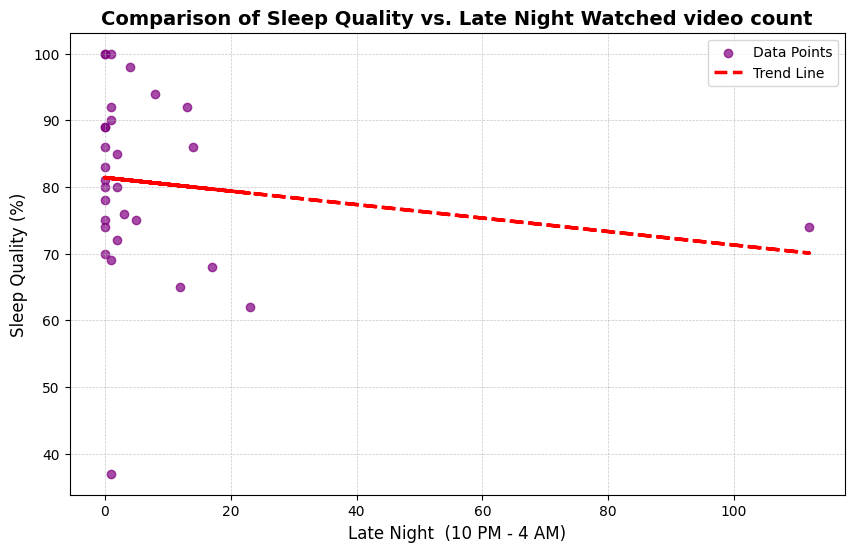

In [10]:
# Filter watch data for videos watched between 10 PM and 3 AM
late_night_watches = watch_data[(watch_data['hour'] >= 22) | (watch_data['hour'] < 4)]

# Calculate total watched videos in the night
late_night_watches['videos_watched'] = 1  
late_night_watch_time = late_night_watches.groupby('date')['videos_watched'].sum().reset_index(name='Late Night Video Watched')

# Merge late-night watch time with sleep data
sleep_data = sleep_data.merge(late_night_watch_time, how='left', left_on='Date', right_on='date')
sleep_data['Late Night Video Watched'] = sleep_data['Late Night Video Watched'].fillna(0)

# Scatter plot: Late Night Video Watched vs. Sleep Quality
plt.figure(figsize=(10, 6))
plt.scatter(sleep_data['Late Night Video Watched'], sleep_data['Sleep Quality'], alpha=0.7, color='purple', label='Data Points')

# Line plot (trend line)
z = np.polyfit(sleep_data['Late Night Video Watched'], sleep_data['Sleep Quality'], 1)
p = np.poly1d(z)
plt.plot(sleep_data['Late Night Video Watched'], p(sleep_data['Late Night Video Watched']), color='red', lw=2.5, linestyle='--', label='Trend Line')

# Improve axis labels, title, and grid
plt.xlabel('Late Night  (10 PM - 4 AM)', fontsize=12)
plt.ylabel('Sleep Quality (%)', fontsize=12)
plt.title('Comparison of Sleep Quality vs. Late Night Watched video count', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.show()


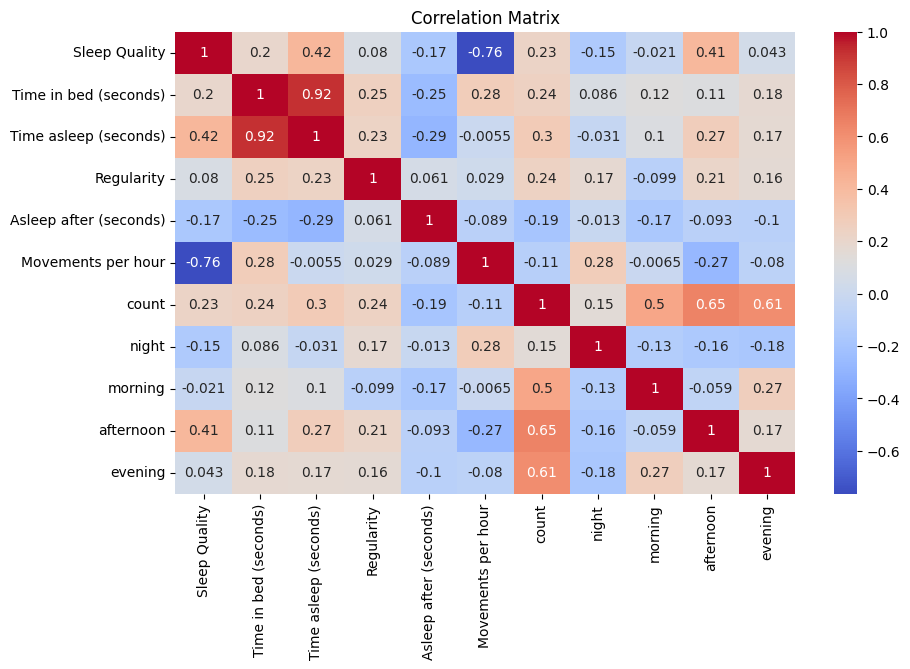

In [11]:
merged_data_heatmap = merged_data[['Sleep Quality', 'Time in bed (seconds)', 'Time asleep (seconds)', 'Regularity', 'Asleep after (seconds)', 'Movements per hour', 'count', 'night', 'morning', 'afternoon', 'evening']]
corr = merged_data_heatmap.corr()

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [12]:

# Step 1: Filter late-night YouTube watching (e.g., 10 PM to 3 AM)
late_night_watch = watch_data[(watch_data['hour'] >= 22) | (watch_data['hour'] < 4)]

# Step 2: Aggregate late-night watching by date
late_night_count = late_night_watch.groupby('date').size().rename('Late Night Videos Watched')

# Step 3: Merge late-night watching data with sleep quality
merged_data = sleep_data.merge(late_night_count, how='left', left_on='Date', right_on='date')
merged_data['Late Night Videos Watched'] = merged_data['Late Night Videos Watched'].fillna(0)

# Step 4: Perform Pearson Correlation
correlation, p_value = pearsonr(merged_data['Sleep Quality'], merged_data['Late Night Videos Watched'])

# Step 5: Output the Results
print(f"Pearson Correlation Coefficient: {correlation}")
print(f"P-Value: {p_value}")

# Interpret Results
if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant correlation between sleep quality and late-night YouTube watching.")
else:
    print("Fail to reject the null hypothesis: No significant correlation between sleep quality and late-night YouTube watching.")

Pearson Correlation Coefficient: -0.15384912812996887
P-Value: 0.4169582399587046
Fail to reject the null hypothesis: No significant correlation between sleep quality and late-night YouTube watching.
